In [1]:
from openpyxl import load_workbook

In [ ]:
import numpy as np

In [13]:
def create_workbook(radius):
    file_path = R'C:\Users\manri\Documents\SAP2000_Python\INPUT\TMCLK_1Ring_TEST_raw.xlsx'
    wb = load_workbook(file_path)
    ws = wb['Joint Coordinates']  # or wb.active
    for row in np.linspace(4,375,372,dtype=int):
        cell = 'D'+str(int(row))
        ws[cell] = radius
    file_path = R'C:\Users\manri\Documents\SAP2000_Python\INPUT\TMCLK_1Ring_TEST_raw'+str(radius)+'.xlsx'
    wb.save(file_path)

radi_options = np.linspace(1,10,10, dtype=int)
for radius in radi_options:
    create_workbook(radius)

In [6]:
import os
import sys
import clr
clr.AddReference("System.Runtime.InteropServices")
from System.Runtime.InteropServices import Marshal

#set the following path to the installed SAP2000 program directory
clr.AddReference(R'C:\Program Files\Computers and Structures\SAP2000 23\SAP2000v1.dll')
from SAP2000v1 import *

def run_sap_model():
    #set the following flag to True to execute on a remote computer
    Remote = False

    #if the above flag is True, set the following variable to the hostname of the remote computer
    #remember that the remote computer must have SAP2000 installed and be running the CSiAPIService.exe
    RemoteComputer = "SpareComputer-DT"

    #set the following flag to True to attach to an existing instance of the program
    #otherwise a new instance of the program will be started
    # AttachToInstance = True
    AttachToInstance = False

    #set the following flag to True to manually specify the path to SAP2000.exe
    #this allows for a connection to a version of SAP2000 other than the latest installation
    #otherwise the latest installed version of SAP2000 will be launched
    SpecifyPath = False

    #if the above flag is set to True, specify the path to SAP2000 below
    ProgramPath = R"C:\Program Files\Computers and Structures\SAP2000 23\SAP2000.exe"

    #full path to the model
    #set it to the desired path of your model
    #if executing remotely, ensure that this folder already exists on the remote computer
    #the below command will only create the folder locally
    APIPath = R'C:\CSi_SAP2000_API_Example'
    if not os.path.exists(APIPath):
        try:
            os.makedirs(APIPath)
        except OSError:
            pass
    ModelPath = APIPath + os.sep + 'API_1-001.sdb'

    #create API helper object
    helper = cHelper(Helper())
    if AttachToInstance:
        #attach to a running instance of SAP2000
        try:
            #get the active SAP2000 object       
            if Remote:
                mySAPObject = cOAPI(helper.GetObjectHost(RemoteComputer, "CSI.SAP2000.API.SAPObject"))
            else:
                mySAPObject = cOAPI(helper.GetObject("CSI.SAP2000.API.SAPObject"))
        except:
            print("No running instance of the program found or failed to attach.")
            sys.exit(-1)
    else:
        if SpecifyPath:
            try:
                #'create an instance of the SAP2000 object from the specified path
                if Remote:
                    mySAPObject = cOAPI(helper.CreateObjectHost(RemoteComputer, ProgramPath))
                else:
                    mySAPObject = cOAPI(helper.CreateObject(ProgramPath))
            except :
                print("Cannot start a new instance of the program from " + ProgramPath)
                sys.exit(-1)
        else:
            try:
                #create an instance of the SAP2000 object from the latest installed SAP2000
                if Remote:
                    mySAPObject = cOAPI(helper.CreateObjectProgIDHost(RemoteComputer, "CSI.SAP2000.API.SAPObject"))
                else:
                    mySAPObject = cOAPI(helper.CreateObjectProgID("CSI.SAP2000.API.SAPObject"))  
            except:
                print("Cannot start a new instance of the program.")
                sys.exit(-1)

        #start SAP2000 application
        mySAPObject.ApplicationStart()
    #create SapModel object
    SapModel = cSapModel(mySAPObject.SapModel)

    #initialize model
    SapModel.InitializeNewModel()
    # #create new blank model
    # File = cFile(SapModel.File)
    # File.NewBlank()
    return SapModel

def load_existing_model(SapModel, radius): 
    # Load Existing Model
    path_tunnel = R'C:\Users\manri\Documents\SAP2000_Python\INPUT\TMCLK_1Ring_TEST_raw'+str(radius)+'.xlsx'
    #     path_tunnel = "C:/Users/manri/Downloads/SAP2000 Model/TMCLK_1Ring_TEST.sdb"
    path_tunnel

    File = cFile(SapModel.File)
    File.OpenFile(path_tunnel)
    #run model (this will create the analysis model)

    Analyze = cAnalyze(SapModel.Analyze)

    ret = Analyze.RunAnalysis()

    #refresh view, update (initialize) zoom

    View = cView(SapModel.View)

    ret = View.RefreshView(0, False)
    #get results
    Results = cAnalysisResults(SapModel.Results)
    Setup = cAnalysisResultsSetup(Results.Setup)
    NumberResults = 0
    Obj = []
    Elm = []
    ACase = []
    StepType = []
    StepNum = []
    U1 = []
    U2 = []
    U3 = []
    R1 = []
    R2 = []
    R3 = []
    ObjectElm = 0
    ret = Setup.DeselectAllCasesAndCombosForOutput()
    ret = Setup.SetCaseSelectedForOutput('ULS1')

    #initialize for results
    U1_result = [] 
    U3_result = [] 
    #get results for joints 1 through 360
    Results = cAnalysisResults(SapModel.Results)
    Setup = cAnalysisResultsSetup(Results.Setup)
    for i in range(1,361):
        [ret, NumberResults, Obj, Elm, ACase, StepType, StepNum, U1, U2, U3, R1, R2, R3] = Results.JointDispl(str(i), ObjectElm, NumberResults, Obj, Elm, ACase, StepType, StepNum, U1, U2, U3, R1, R2, R3)
        U1_result.append(U1[0])
        U3_result.append(U3[0])
    return U1_result, U3_result

In [7]:
SapModel = run_sap_model()

In [10]:
U1_result_rad_dict = dict()
U3_result_rad_dict = dict()

In [14]:
for radius in radi_options:
    U1_result_rad_dict[str(radius)], U3_result_rad_dict[str(radius)] = load_existing_model(SapModel, radius)

In [10]:
#close the program
ret = mySAPObject.ApplicationExit(False)
SapModel = None
mySAPObject = None

In [11]:
# Plot results
import math
import matplotlib.pyplot as plt


In [22]:
import matplotlib.pyplot as plt

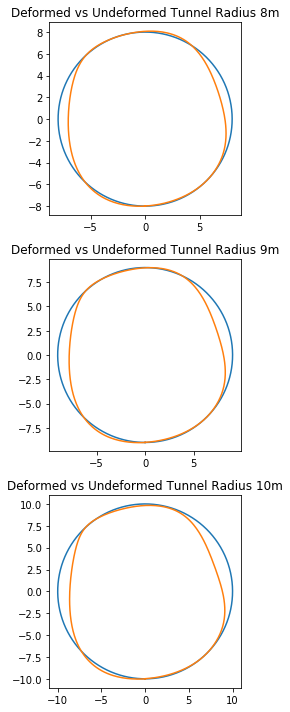

In [42]:
figure, axes_array = plt.subplots(3)

radius = 8

for axes in axes_array:
    theta = np.linspace(-1/4*2*np.pi, 3/4*2*np.pi, 360)
    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    x = radius*np.cos(theta)+100*np.array(U1_result_rad_dict[str(radius)])
    y = radius*np.sin(theta)+100*np.array(U3_result_rad_dict[str(radius)])

    axes.plot(a, b)
    axes.plot(x, y)
    axes.set_aspect(1)
    axes.title.set_text('Deformed vs Undeformed Tunnel Radius ' + str(radius) + 'm')
    radius += 1


figure.set_figheight(10)
figure.set_figwidth(5)
plt.tight_layout()
plt.show()